In [1]:
import os
import sys
import contextlib
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from argparse import Namespace

sns.set(context="talk", palette="husl", color_codes=True)


class DummyFile(object):
    def write(self, x): pass

@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = DummyFile()
    yield
    sys.stdout = save_stdout


def read_fit_elines_rss(filename):
    iseg = 0
    wave__s, flux__s, eflux__s, vel__s, evel__s, sig__s, esig__s = [], [], [], [], [], [], []
    mtypes, wlc, flx, e_flx, sig, e_sig, vel, e_vel = [], [], {}, {}, {}, {}, {}, {}
    with open(filename) as f:
        for line in f:
            if line.startswith("#"):
                last_seg = iseg
                iseg = int(line.split()[-1])
                if iseg != last_seg:
                    mtypes, wlc, flx, e_flx, sig, e_sig, vel, e_vel = [], [], {}, {}, {}, {}, {}, {}
            nmod, _ = tuple(eval(v) for v in f.readline()[:-1].split())
            for _ in range(nmod):
                line_model = f.readline()[:-1].split()
                mtype = line_model[0]
                if mtype == "eline":
                    mtypes.append(mtype)
                    wl = eval(line_model[1])
                    wlc.append(wl)
                    
                    flx[wl] = eval(line_model[3])
                    e_flx[wl] = eval(line_model[4])
                    sig[wl] = eval(line_model[5])
                    e_sig[wl] = eval(line_model[6])
                    vel[wl] = eval(line_model[7])
                    e_vel[wl] = eval(line_model[8])
            wave__s.append(wlc)
            flux__s.append(flx)
            eflux__s.append(e_flx)
            vel__s.append(vel)
            evel__s.append(e_vel)
            sig__s.append(sig)
            esig__s.append(e_sig)

    ns = last_seg + 1
    wave__m = np.unique(np.concatenate(wave__s))
    flux__ms = np.zeros((wave__m.size, ns))
    eflux__ms = np.zeros((wave__m.size, ns))
    sig__ms = np.zeros((wave__m.size, ns))
    esig__ms = np.zeros((wave__m.size, ns))
    vel__ms = np.zeros((wave__m.size, ns))
    evel__ms = np.zeros((wave__m.size, ns))

    for iwl in range(wave__m.size):
        for iseg in range(ns):
            flux__ms[iwl, iseg] = flux__s[iseg].get(wave__m[iwl], 0.0)
            eflux__ms[iwl, iseg] = eflux__s[iseg].get(wave__m[iwl], 0.0)
            sig__ms[iwl, iseg] = sig__s[iseg].get(wave__m[iwl], 0.0)
            esig__ms[iwl, iseg] = esig__s[iseg].get(wave__m[iwl], 0.0)
            vel__ms[iwl, iseg] = vel__s[iseg].get(wave__m[iwl], 0.0)
            evel__ms[iwl, iseg] = evel__s[iseg].get(wave__m[iwl], 0.0)
    
    return wave__m, flux__ms, eflux__ms, vel__ms, evel__ms, sig__ms, esig__ms

In [2]:
SIM_NAME = "DIG_bright"
EXP_TIME = 900

SIM_PATH = f"_data-sim/{SIM_NAME}/outputs"

SIMPLE_SIM_NAME = f"{SIM_NAME}_linear_full_{EXP_TIME}_flux.fits"

current_sim = SIMPLE_SIM_NAME
out_fl_name = os.path.join(SIM_PATH, current_sim.replace(".fits", ".fl.rss.fits"))
out_ef_name = os.path.join(SIM_PATH, current_sim.replace(".fits", ".ef.rss.fits"))

In [3]:
args = Namespace()
args.spec_file = out_fl_name
args.error_file = out_ef_name

args.single_gas_fit = True
args.ignore_gas = False

args.emission_lines_file = "../../_fitting-data/_configs/MaNGA/emission_lines_long_list.MaNGA"
args.output_path = "_data/out"

args.sigma_gas = 3

args.config_file = None

args.rsp_file = "../../_fitting-data/_basis_mastar_v3.1.1/stellar-basis-spectra-100.fits.gz"
args.rsp_nl_file = "../../_fitting-data/_basis_mastar_v3.1.1/stellar-basis-spectra-10.fits.gz"

args.mask_file = None

args.sigma_inst = 0.001
args.flux_scale = -np.inf, np.inf

args.w_range = 3650.0, 9800.0
args.w_range_nl = 3800, 4700

args.redshift = 0, 0, 0, 0.1
args.sigma = 0, 0, 0, 350
args.AV = 0, 0, 0, 1.5

args.plot = 0
args.ratio = True
args.y_ratio = None
args.fit_sigma_rnd = True

args.label = current_sim.replace(".fits", "")

out_file_elines = os.path.join(args.output_path, f"elines_{args.label}")
out_file_single = os.path.join(args.output_path, f"single_{args.label}")
out_file_coeffs = os.path.join(args.output_path, f"coeffs_{args.label}")
out_file_fit = os.path.join(args.output_path, f"output.{args.label}.fits.gz")
out_file_ps = os.path.join(args.output_path, args.label)

In [38]:
from astropy.io import fits
from astropy.table import Table


with fits.open(os.path.join(SIM_PATH, current_sim)) as f:
    ra, dec = f[0].header["OBS_RA"]*u.deg, f[0].header["OBS_DEC"]*u.deg
    wl = f["WAVE"].data
    flux_rss = f["TARGET"].data[:,(wl>=6555)&(wl<=6567)].sum(axis=1)
    fibers_table = Table.read(f["FIBERID"])

size = fibers_table["diameter"][0] * fibers_table["diameter"].unit

fibers_table

id,ring,position,x,y,diameter,dispersion
,,,arcsec,arcsec,arcsec,pix
int64,int64,int64,float64,float64,float64,float64
0,1,0,1.546738304939677e-27,0.0,35.3,3.0
1,2,0,18.4999999504005,-32.042939553375824,35.3,3.0
2,2,1,-18.499999950445808,-32.04293955337582,35.3,3.0
3,2,2,36.99999960315852,1.2632342130702194e-11,35.3,3.0
4,2,3,-36.9999996031917,1.2623279744534303e-11,35.3,3.0
5,2,4,18.49999995040049,32.042939553401084,35.3,3.0
6,2,5,-18.499999950445808,32.04293955340108,35.3,3.0
7,3,0,36.99999960315134,-64.0858767868585,35.3,3.0


In [40]:
from astropy import units as u
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch


# ra = 12.34 * u.degree
# dec = -20.35 * u.degree
# size = 35.3 * u.arcmin
pxsize = 1 * u.arcsec
obs_coords = SkyCoord(ra, dec)

# initializing the wcs object
wcs = WCS(naxis=2)

# setting up the different fields
npixels = np.round((size.to(u.arcsec) / pxsize.to(u.arcsec)).value/2.).astype(int) * 2 + 1
wcs.wcs.crpix = [npixels / 2, npixels / 2]
wcs.wcs.cdelt = np.array([-pxsize.to(u.deg).value, pxsize.to(u.deg).value])
wcs.wcs.crval = [ra.to(u.deg).value, dec.to(u.deg).value]
wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]

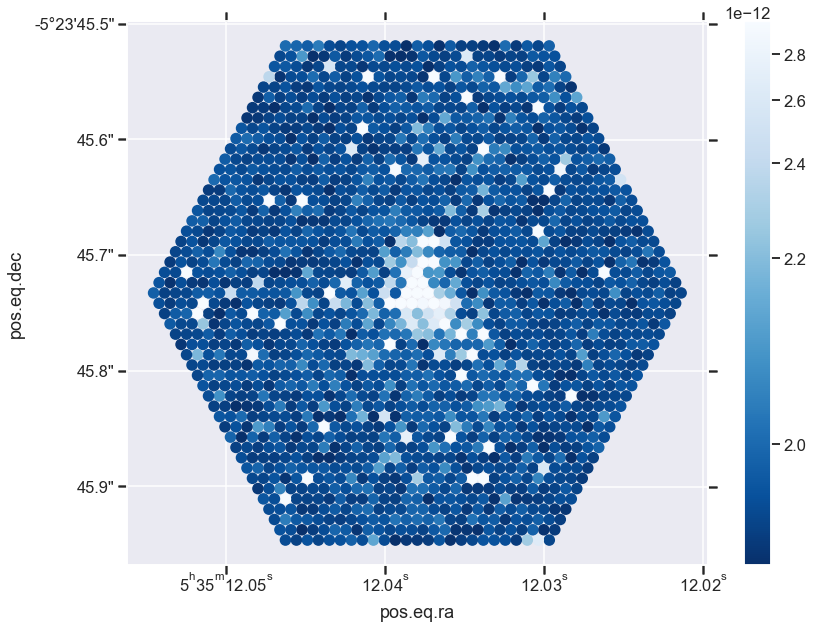

In [49]:
fig, ax = plt.subplots(figsize=(13,10), subplot_kw=dict(projection=wcs))

ids, x, y = [], [], []
for fiber in fibers_table:
    fiber_coord = obs_coords.spherical_offsets_by(fiber["x"]*u.arcsec, fiber["y"]*u.arcsec)

    ids.append(fiber["id"])
    x.append(fiber_coord.ra.value)
    y.append(fiber_coord.dec.value)
    # p = SphericalCircle((fiber_coord.ra, fiber_coord.dec), fiber["diameter"]*u.arcsec / 2,
    #                     edgecolor='green', facecolor='none',
    #                     transform=ax.get_transform('fk5'))
    # ax.add_patch(p)

norm = ImageNormalize(flux_rss, stretch=AsinhStretch(), interval=PercentileInterval(95.))
cm = ax.scatter(np.asarray(x), np.asarray(y), c=flux_rss, s=100, cmap="Blues_r", norm=norm)
plt.colorbar(cm)
xlim, ylim = ax.get_xlim(), ax.get_ylim()
# ax.set_xlim(xlim[::-1])
plt.show()

In [50]:
# NSA flujo en UV correla con Halpha
# superponer nebulosas sobre el fondo
# cambiar la intensidad maxima de la linea (cambiar en factores 1/2)

In [103]:
wave__m, flux__ms, eflux__ms, vel__ms, evel__ms, sig__ms, esig__ms = read_fit_elines_rss(out_file_elines)

# wl = 3970.07
# wl = 5006.84
wl = 6562.85
# wl = 7774.
flx_map__yx = flux__ms[np.where(wave__m==wl)].ravel()
vel_map__yx = vel__ms[np.where(wave__m==wl)].ravel()
sig_map__yx = sig__ms[np.where(wave__m==wl)].ravel()

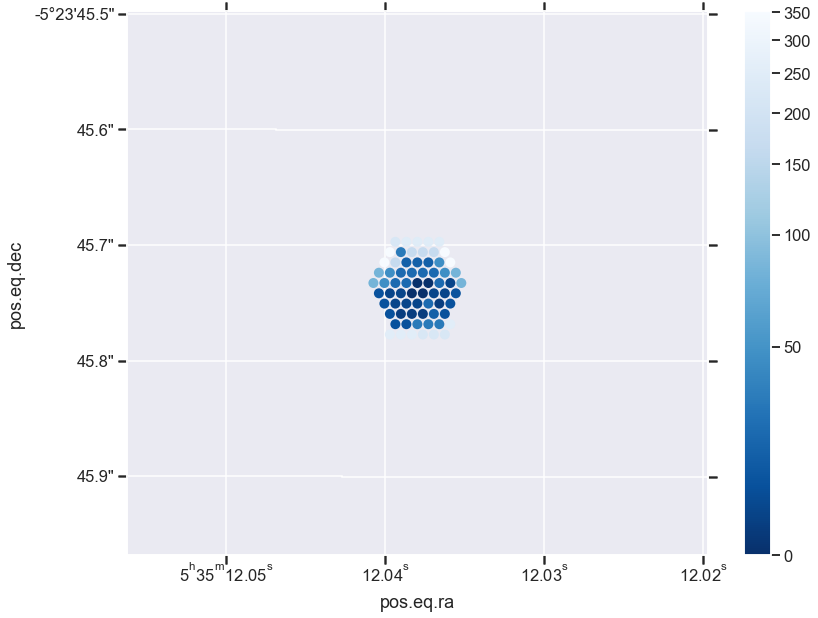

In [107]:
z = np.full_like(x, fill_value=np.nan, dtype=np.double)
# z = np.zeros_like(x)

fitted_ids = np.arange(flx_map__yx.size, dtype=int)
z[fitted_ids] = flx_map__yx

norm = ImageNormalize(z[fitted_ids], stretch=AsinhStretch(), interval=PercentileInterval(95.))
fig, ax = plt.subplots(figsize=(13,10), subplot_kw=dict(projection=wcs))
mp = ax.scatter(x, y, c=z, s=100, lw=0, cmap="Blues_r", norm=norm)
plt.colorbar(mp)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()